# The spam filter

## Miguel Ángel Canela, IESE Business School

******

### Introduction

In this example, I develop a **spam filter**, that is, an algorithm which classifies e-mail messages as either spam or non-spam, based on a collection of **numeric features** such as the frequency of certain words or characters. The algorithm is based on a **decision tree** obtained with the class `DecisionTreeClassifier` from the scikit-learn module `tree`. An alternative analysis can be performed with the class `DecisionTreeRegressor`, but I leave this for the homework. In this example, I have to take into account that the **false positive rate**, that is, the proportion of non-spam messages wrongly classified as spam, must be very low in an acceptable spam filter. 

I use data collected at Hewlett-Packard by merging: (a) a collection of spam e-mail from the company postmaster and the individuals who had filed spam, and (b) a collection of non-spam e-mail, extracted from filed work and personal e-mail. The data set contains data on 4,601 e-mail messages. Among these messages, 1,813 have been classified as spam. The variables are:

* 48 numeric features whose names start with 'word_', followed by a word. They indicate the **frequency**, in percentage scale, with which that word appears in the message. Example: for a particular message, `word_make=0.21` means that 0.21% of the words in the message match the word 'make'.

* 3 numeric features indicating, respectively, the **average length** of uninterrupted sequences of capital letters, the length of the longest uninterrupted sequence of capital letters and the total number of capital letters in the message.

* A label 1/0 indicating whether that e-mail is spam (`spam`).

### Importing the data

I import the data with the `pandas` function `read_csv`. The data set has 4,601 rows and 52 columns, all numeric. I print the structure of the data set only for the first and the last five variables.

In [1]:
import pandas as pd
fname = 'https://raw.githubusercontent.com/mcanela-iese/ML_Course/master/Data/' \
     'spam.csv'
df = pd.read_csv(fname)

In [2]:
df.iloc[:, 0:5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 5 columns):
word_make       4601 non-null float64
word_address    4601 non-null float64
word_all        4601 non-null float64
word_3d         4601 non-null float64
word_our        4601 non-null float64
dtypes: float64(5)
memory usage: 179.9 KB


In [3]:
df.iloc[:, 47:52].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 5 columns):
word_conference    4601 non-null float64
cap_ave            4601 non-null float64
cap_long           4601 non-null int64
cap_total          4601 non-null int64
spam               4601 non-null int64
dtypes: float64(2), int64(3)
memory usage: 179.9 KB


### Building a decision tree

I take last column of this data frame (`spam`) as the **target vector**. The other 51 columns form the **features matrix**. I specify them as usual in scikit-learn **supervised methods**.

In [4]:
y = df.iloc[:, 51]
X = df.iloc[:, 0:51]

Fitting a decision tree is the same as fitting any other supervised learning model in `scikit-learn`. There are many ways of controlling the growth of the tree. To start the discussion, I want a small tree which can be  plotted and visually examined. So, I use `man_depth=2`, which gives me a tree of 4 leaves. For the rest of the arguments, which are printed below, I accept the default values. 

*Note*. Update scikit-learn to the current version if you to get all the results that follow. 

In [5]:
from sklearn import tree
treeclf = tree.DecisionTreeClassifier(max_depth=2)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

A quick evaluation is given in scikit-learn by the attribute `score`, which, in regression models, gives the R-squared statistic and, in classification models, the **accuracy**.

In [6]:
round(treeclf.score(X, y), 3)

0.834

### Plotting the tree

Before evaluating the classifier, I will show you the tree, for a better understanding of how it works. Of course, examining the tree only makes sense when the tree is small, so this is done here for didactic purposes only. There are two ways of showing explicitly a decision tree, text report and graphics.

A text report can be obtained in `sklearn.tree` with the class `export_text`, as follows: 

In [7]:
print(tree.export_text(treeclf, feature_names=list(X.columns)))

|--- word_remove <= 0.01
|   |--- word_free <= 0.13
|   |   |--- class: 0
|   |--- word_free >  0.13
|   |   |--- class: 1
|--- word_remove >  0.01
|   |--- word_george <= 0.08
|   |   |--- class: 1
|   |--- word_george >  0.08
|   |   |--- class: 0



For the graphical presentation, I use the class `export_graphviz`, which exports the tree to a format (`dot`) which can be managed by **Graphviz**. Graphviz is an open source app, not part of Python, which you need to have installed in your computer to visualize the tree on your screen. The three last lines of the following code chunk are used for generating a PDF version of the DOT representation. 

In [8]:
dot_data = tree.export_graphviz(treeclf, out_file=None,
  feature_names=df.columns[0:51])
# import pydotplus
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('tree.pdf')

Assuming that Graphviz is installed, I import the module `graphviz` and ask for the plot. Note: the first two lines are needed in Windows for Python to find the Graphviz executable. In Macintosh, installing Graphviz with Homebrew fixes this type of problem.

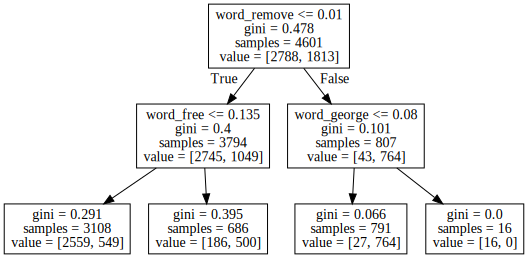

In [9]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import graphviz
graphviz.Source(dot_data)

This graph is easy to interpret. The box on top (depth zero) is the root node, with 4,601 instances, of which 1,813 are spam. The current value of the Gini measure of impurity is 0.478. The **optimal split**, based on `word_remove`, is the one that yields the maximum impurity reduction, meaning the lowest value for the weighted average of the Gini values of the branches. At depth one, the current Gini value is

$${\rm gini} = {3794\times 0.4 + 807 \times 0.101 \over 4601} = 0.348.$$

We repeat the process at the two nodes at depth one. The optimal splits use the features `word_free` and `word_george`. The impurity keeps decreasing, and, in one of the nodes at depth two is already null, so if we relax the maximum depth constraint, this branch will not be further split.

What are the predictions in the four leaves? Unless we change it by applying our own cutoff, they are based on majority (this would be equivalent to 0.5 cutoff). So, the predicted class in leaves 2 and 3 is spam and the predicted class in leaves 1 and 4 is non-spam. How good is this? Since, the objective is to develop a spam filter, our main concern is the false positive rate, that is, the proportion of legal that would be stopped by the filter. In this tree, we have 186 false positives in leave 2 and 27 false positives in leave 3, a total 213 (4.6%). Of course, the false negatives (549) also matter, but the main challenge is to reduce this 4.6% by allowing the tree to grow beyond depth two.

### Confusion matrix

Plotting the tree and evaluating its predictive performance by visual inspection is only feasible for very small trees. So, we take now an approach based on the classification metrics provided by the module `metrics` of scikit-learn, in particular on the **confusion matrix** and the statistics derived from it. The matrix can be obtained directly the Pandas function `crosstab`, or using ad hoc resources from scikit-learn, which is what I do here.

First, the predictions are extracted from the tree with the attribute `predict`.

In [10]:
y_pred = treeclf.predict(X)

Now, I import the module `metrics` and calculate the matrix.

In [11]:
from sklearn import metrics
conf = metrics.confusion_matrix(y, y_pred)
conf

array([[2575,  213],
       [ 549, 1264]])

The **precision** and the **recall** are given directly by the corresponding functions:

In [12]:
round(metrics.precision_score(y, y_pred), 3)

0.856

In [13]:
round(metrics.recall_score(y, y_pred), 3)

0.697

Note that, in this case, the data set has been artificially created, by joining two collections which come from different sources. So, the proportion of spam in the data is not the real one. This means that statistics like the accuracy and the precision do not make sense. Nevertheless, we can evaluate the classifier by examining the two rows of the confusion matrix separately, that is, looking at the **true positive rate**, which is the same as the recall, and **false positive rate**. If you are interested, you can get these statiscs directly with:

The TP rate is not bad, meaning that 70% of the spam messages are filtered out, but the FP rate is a bit high for a spam filter. Can we improve these results with a better cutoff? Instead of exploring this with histograms, it is better to use crosstabulation here, since there are only 4 different scores, one for each leaf of the tree. 

In [14]:
import numpy as np
tp = conf[1, 1]/np.sum(conf[1, :])
round(tp, 3)

0.697

In [15]:
fp = conf[0, 1]/np.sum(conf[0, :])
round(fp, 3)

0.076

### Controlling the growth of the tree

The growth of the tree can be controlled in many ways in the class `DecisionTreeClassifier`. Since I started using the maximum depth, I continue with it.

In [16]:
treeclf = tree.DecisionTreeClassifier(max_depth=3)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
y_pred = treeclf.predict(X)
conf = metrics.confusion_matrix(y, y_pred)
conf

array([[2598,  190],
       [ 406, 1407]])

The improvement is clear, both in false positives and false negatives. The statistics are:

In [18]:
tp = conf[1, 1]/np.sum(conf[1, :])
round(tp, 3)

0.776

In [19]:
fp = conf[0, 1]/np.sum(conf[0, :])
round(fp, 3)

0.068

The confusion matrix looks a bit better, but we should check that this does not come at the price of **overfitting**. I leave that for the homework.

### Feature importance

One of the advantages of decision tree classifiers is that it is very easy to get a report on the **importance** of every feature. The importance of a feature is computed as the proportion of impurity decrease brought by that feature. The attribute `feature_importances_` gives a vector containing importance values for all the features. Value zero signals that the corresponding feature is not used in the tree.

In [20]:
treeclf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.50346408, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28862986, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13377951, 0.04335074,
       0.        , 0.02464125, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00613457, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

To get these values sorted can help with big trees. When every feature involved in the tree is used only in one split, the importance ranking coincides with the order in which the features get involved in the generation of the splits.

In [21]:
pd.Series(data=treeclf.feature_importances_, index=X.columns).sort_values(ascending=False).head(6)

word_remove    0.503464
word_free      0.288630
word_money     0.133780
word_hp        0.043351
word_george    0.024641
word_edu       0.006135
dtype: float64